# Connecting data challenge outputs to input truth #

This tutorial documents how to connect reference run outputs back to the input truth.  It uses the "19.12" reference run available at NERSC in
```
/global/cfs/cdirs/desi/datachallenge/reference_runs/19.12
```
See https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop/JuneMeeting for
instructions on installing the DESI code.  The bottom of this tutorial lists the code versions used while testing this.

Stephen Bailey<br/>
January 2020

## Basic setup ##

The first portion of this tutorial doesn't require any DESI-specific code,
so just load the minimal set of external dependencies needed here.

In [20]:
import os
import numpy as np
import astropy.table
import desitutorials
reference_run = '19.12'
%pylab inline

Populating the interactive namespace from numpy and matplotlib


For convenience, move into the directory containing the reference run data.  The following is where this is located at NERSC.

In [21]:
os.chdir(os.path.join(os.environ['DESI_ROOT'], 'datachallenge', 'reference_runs', reference_run))

## Comparing the redshift catalog to the input truth ##

Read in the redshift catalog, targets, and truth files.

In [22]:
zcat = astropy.table.Table.read('spectro/redux/mini/zcatalog-mini.fits', hdu=1)
targets_bright = astropy.table.Table.read('targets/targets-bright.fits', hdu=1)
targets_dark = astropy.table.Table.read('targets/targets-dark.fits', hdu=1)
truth_bright = astropy.table.Table.read('targets/truth-bright.fits', hdu=1)
truth_dark = astropy.table.Table.read('targets/truth-dark.fits', hdu=1)

In [23]:
#
# Strip trailing spaces from TEMPLATETYPE column.
#
truth_bright['TEMPLATETYPE'][:] = np.char.strip(truth_bright['TEMPLATETYPE'][:])
truth_dark['TEMPLATETYPE'][:] = np.char.strip(truth_dark['TEMPLATETYPE'][:])
print('Updated set of template types:', set(truth_dark['TEMPLATETYPE']) | set(truth_bright['TEMPLATETYPE']))

Updated set of template types: {'STAR', 'LRG', 'QSO', 'ELG', 'WD', 'BGS'}


Let's look at what columns each of these tables has, and then merge the `zcat` and `truth` tables together.

In [24]:
def print_colnames(table_name, tx):
    print('{}.colnames:'.format(table_name))
    for i in range(0, len(tx.colnames), 8):
        print('    '+' '.join(tx.colnames[i:i+8]))

print_colnames('zcat', zcat)
print_colnames('targets', targets_dark)
print_colnames('truth', truth_dark)

zcat.colnames:
    TARGETID CHI2 COEFF Z ZERR ZWARN NPIXELS SPECTYPE
    SUBTYPE NCOEFF DELTACHI2 NUMEXP NUMTILE RELEASE BRICKID BRICKNAME
    BRICK_OBJID MORPHTYPE RA DEC RA_IVAR DEC_IVAR FLUX_G FLUX_R
    FLUX_Z FLUX_W1 FLUX_W2 FLUX_W3 FLUX_W4 FLUX_IVAR_G FLUX_IVAR_R FLUX_IVAR_Z
    FLUX_IVAR_W1 FLUX_IVAR_W2 FLUX_IVAR_W3 FLUX_IVAR_W4 MW_TRANSMISSION_G MW_TRANSMISSION_R MW_TRANSMISSION_Z MW_TRANSMISSION_W1
    MW_TRANSMISSION_W2 MW_TRANSMISSION_W3 MW_TRANSMISSION_W4 NOBS_G NOBS_R NOBS_Z FRACFLUX_G FRACFLUX_R
    FRACFLUX_Z FRACMASKED_G FRACMASKED_R FRACMASKED_Z FRACIN_G FRACIN_R FRACIN_Z ALLMASK_G
    ALLMASK_R ALLMASK_Z WISEMASK_W1 WISEMASK_W2 PSFDEPTH_G PSFDEPTH_R PSFDEPTH_Z GALDEPTH_G
    GALDEPTH_R GALDEPTH_Z FRACDEV FRACDEV_IVAR SHAPEDEV_R SHAPEDEV_R_IVAR SHAPEDEV_E1 SHAPEDEV_E1_IVAR
    SHAPEDEV_E2 SHAPEDEV_E2_IVAR SHAPEEXP_R SHAPEEXP_R_IVAR SHAPEEXP_E1 SHAPEEXP_E1_IVAR SHAPEEXP_E2 SHAPEEXP_E2_IVAR
    FIBERFLUX_G FIBERFLUX_R FIBERFLUX_Z FIBERTOTFLUX_G FIBERTOTFLUX_R FIBERTOTFLU

In [25]:
ztruth = astropy.table.join(zcat, truth_dark, keys='TARGETID')
print_colnames('ztruth', ztruth)

ztruth.colnames:
    TARGETID CHI2 COEFF Z ZERR ZWARN NPIXELS SPECTYPE
    SUBTYPE NCOEFF DELTACHI2 NUMEXP NUMTILE RELEASE BRICKID BRICKNAME
    BRICK_OBJID MORPHTYPE RA DEC RA_IVAR DEC_IVAR FLUX_G_1 FLUX_R_1
    FLUX_Z_1 FLUX_W1_1 FLUX_W2_1 FLUX_W3_1 FLUX_W4_1 FLUX_IVAR_G FLUX_IVAR_R FLUX_IVAR_Z
    FLUX_IVAR_W1 FLUX_IVAR_W2 FLUX_IVAR_W3 FLUX_IVAR_W4 MW_TRANSMISSION_G MW_TRANSMISSION_R MW_TRANSMISSION_Z MW_TRANSMISSION_W1
    MW_TRANSMISSION_W2 MW_TRANSMISSION_W3 MW_TRANSMISSION_W4 NOBS_G NOBS_R NOBS_Z FRACFLUX_G FRACFLUX_R
    FRACFLUX_Z FRACMASKED_G FRACMASKED_R FRACMASKED_Z FRACIN_G FRACIN_R FRACIN_Z ALLMASK_G
    ALLMASK_R ALLMASK_Z WISEMASK_W1 WISEMASK_W2 PSFDEPTH_G PSFDEPTH_R PSFDEPTH_Z GALDEPTH_G
    GALDEPTH_R GALDEPTH_Z FRACDEV FRACDEV_IVAR SHAPEDEV_R SHAPEDEV_R_IVAR SHAPEDEV_E1 SHAPEDEV_E1_IVAR
    SHAPEDEV_E2 SHAPEDEV_E2_IVAR SHAPEEXP_R SHAPEEXP_R_IVAR SHAPEEXP_E1 SHAPEEXP_E1_IVAR SHAPEEXP_E2 SHAPEEXP_E2_IVAR
    FIBERFLUX_G FIBERFLUX_R FIBERFLUX_Z FIBERTOTFLUX_G FIBERTOTFL

Make a histogram of $\Delta v = c (z - z_{\mathrm{true}}) / (1 + z_{\mathrm{true}})$ for each object type:

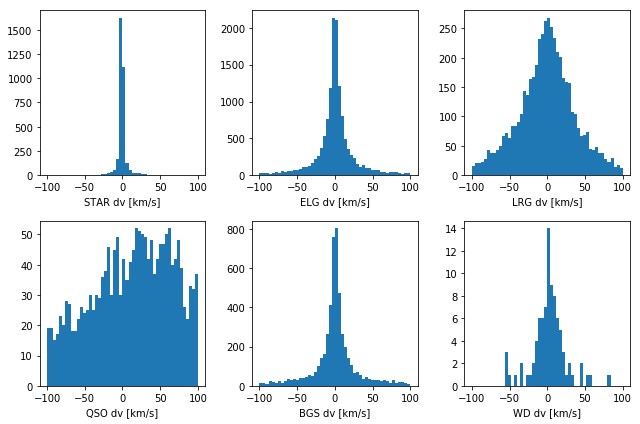

In [26]:
dv = 3e5 * (ztruth['Z'] - ztruth['TRUEZ']) / (1 + ztruth['TRUEZ'])
figure(figsize=(9,6))
for i, objtype in enumerate(set(ztruth['TEMPLATETYPE'])):
    subplot(2,3,1+i)
    ii = ztruth['TEMPLATETYPE'] == objtype
    hist(dv[ii], 50, (-100, 100))
    xlabel('{} dv [km/s]'.format(objtype))
tight_layout()

## Comparing spectra to truth

For this next section, we will use some `desispec` code so load that now and set
some environment variables so that `desispec.io` can find the data files.  This
assumes that we are still in the reference run data directory.

In [27]:
import astropy.io.fits
import desispec.io
os.environ['DESI_SPECTRO_REDUX'] = os.path.join(os.getcwd(), 'spectro', 'redux')
os.environ['SPECPROD'] = 'mini'

Read some spectra and find out what bricks they are on

In [28]:
specfile = desispec.io.findfile('spectra', groupname='5299', nside=64)
spectra = desispec.io.read_spectra(specfile)

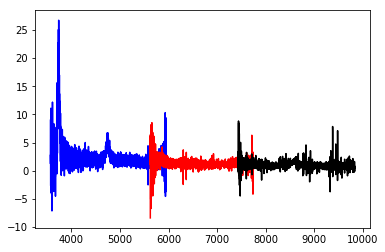

In [29]:
itarget = 7
plot(spectra.wave['b'], spectra.flux['b'][itarget], color='b')
plot(spectra.wave['r'], spectra.flux['r'][itarget], color='r')
plot(spectra.wave['z'], spectra.flux['z'][itarget], color='k')

In [30]:
spectra.fibermap['OBJTYPE', 'TARGETID', 'BRICKNAME', 'TARGET_RA', 'TARGET_DEC'][itarget]

OBJTYPE,TARGETID,BRICKNAME,TARGET_RA,TARGET_DEC
bytes3,int64,bytes8,float64,float64
TGT,288230398377332650,1517p325,151.8081512451172,32.59611511230469


What's the truth and redrock fit results for this target?

In [31]:
ii = ztruth['TARGETID'] == spectra.fibermap['TARGETID'][itarget]
ztruth['TEMPLATETYPE', 'TRUEZ', 'SPECTYPE', 'Z', 'ZERR', 'ZWARN'][ii]

TEMPLATETYPE,TRUEZ,SPECTYPE,Z,ZERR,ZWARN
str10,float32,str6,float64,float64,int64
QSO,2.0700982,QSO,2.0698619612032574,0.00011498358613129653,0


The actual true input spectra were not included with dc17a, but they are available at
NERSC in:
```
/project/projectdirs/desi/datachallenge/dc17a-twopct/targets/{group}/truth-{brickname}.fits
```
where `group = brickname[0:3]`, i.e. the first 3 characters of the brickname.

**NOTE**: future data challenges will group the input truth files by healpix like the output spectra, but dc17a did not.

The above target came from brickname 0084m085.  If you are running locally (not at NERSC), go get that file now, e.g.
```
mkdir -p targets/008/
scp edison.nersc.gov:/scratch2/scratchdirs/sjbailey/desi/dc17a/targets/008/truth-0084m085.fits targets/008/
```
Let's see what is in that file:

In [32]:
datadir = '/global/cfs/cdirs/desi/datachallenge/dc17a-twopct'
fx = astropy.io.fits.open(datadir+'/targets/008/truth-0084m085.fits')
print(fx.info())
truewave = fx['WAVE'].data
trueflux = fx['FLUX'].data
truemeta = fx['TRUTH'].data

FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/cdirs/desi/datachallenge/dc17a-twopct/targets/008/truth-0084m085.fits'

It has the true wavelength, flux, and a TRUTH table which is just a subset
of the rows in the the truth file that we previously read.  Let's get the index for
the spectrum that we plotted above

In [ ]:
itruth = np.where(truemeta['TARGETID'] == spectra.fibermap['TARGETID'][itarget])[0][0]

Does that look right?

**NOTE**: the truth templates are stored in units of erg/(s cm2 Angstrom) while
the output spectra are inunits of 1e-17 erg/(s cm2 Angstrom).  We might standardize that
in the future...

In [ ]:
itarget = 7
plot(spectra.wave['b'], spectra.flux['b'][itarget], color='b')
plot(spectra.wave['r'], spectra.flux['r'][itarget], color='r')
plot(spectra.wave['z'], spectra.flux['z'][itarget], color='k')
plot(truewave, 1e17*trueflux[itruth], 'y-')
ylim(-1, 3)

**BUG**: Note the unphysical jump in the template around 9200 Angstrom;
That is the cause of many redshift failures, though redrock did get this one right.  That step has been fixed in later software releases.

## Further work
This tutorial used `astropy.table.Table` to read the catalogs
and `astropy.table.join` to merge them in a database-like manner.
This is convenient, but won't scale to the full DESI dataset.  Reading
files with `fitsio` and matching via numpy logic will be more scalable,
but is not yet documented here.

**TODO**: add example reading with fitsio and matching tables with numpy.

**TODO**: add a section on finding and querying the spectro catalog database.

## Code versions used ##
This is at the bottom of the tutorial so that python can introspect what was actually
used instead of just what we thought was used

In [ ]:
print('Code versions used for this tutorial:')
desitutorials.print_code_versions()